# SETUP

The first part of the code sets up the pca_wavelet network, the training comes later. Most of this code comes from the original authors

In [1]:
import sys
sys.path.append('../segmentation_helper')

import tensorflow as tf
import keras
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import data_loader as dl
import model_broker as mb
import os

GPU device not found
Found GPU at: 


In [2]:
tf.keras.backend.set_floatx("float64")

In [56]:
test_size=300
loader = dl.DataLoader(IMAGE_SIZE=256,dataset="pets")
img_ds = loader.import_processed_img()
seg_ds = loader.import_processed_seg()
cardinality = int(img_ds.cardinality())

img_test = img_ds.take(test_size)
seg_test = seg_ds.take(test_size)
img_train = img_ds.skip(test_size)
seg_train = seg_ds.skip(test_size)    

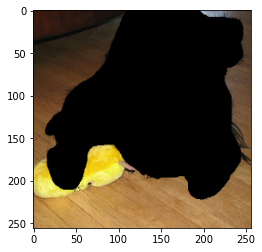

In [57]:
plt.imshow((next(iter(seg_train))[0]))

In [58]:
img_broker = mb.ModelBroker(trainset=img_train,
                            testset=img_test,
                            dirname="bird_img",
                            keep_percent=0.1,
                            count=3,
                            sample_size=100)
                            #activity_regularizer = scaledtanh,
                            #inverse_activity_regularizer=scaledatanh,
                            #activation_before=True)
imghead,imginvhead = img_broker.build_model()
imghead,imginvhead = img_broker.load_model()                                      


keep_percent 0.20629283704945683
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 128.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 5 keep_max 12.0
keep_channels 5
ufilts.shape (1, 1, 1, 27, 5)
end loop 128.0
Starting level 1
Completing 64.0
pca shape tf.Tensor([45 45], shape=(2,), dtype=int32)
keep_channels 9 keep_max 80.0
keep_channels 9
ufilts.shape (1, 1, 1, 45, 9)
end loop 64.0
Starting level 2
Completing 32.0
pca shape tf.Tensor([81 81], shape=(2,), dtype=int32)
keep_channels 16 keep_max 576.0
keep_channels 16
ufilts.shape (1, 1, 1, 81, 16)
end loop 32.0
saving to: models/bird_img
out.shape (1, 32, 32, 16)
keep_percent 0.20629283704945683
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 128.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 5 keep_max 12.0
keep_channels 5
ufil

In [59]:
seg_broker = mb.ModelBroker(trainset=seg_train,
                            testset=seg_test,
                            dirname="bird_seg",
                            keep_percent=0.1,
                            count=3,
                            sample_size=100)
                            #activity_regularizer =scaledtanh ,
                            #inverse_activity_regularizer=scaledatanh ,
                            #activation_before=False)
seghead,seginvhead = seg_broker.build_model()                                        
seghead,seginvhead = seg_broker.load_model()

keep_percent 0.20629283704945683
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 128.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 5 keep_max 12.0
keep_channels 5
ufilts.shape (1, 1, 1, 27, 5)
end loop 128.0
Starting level 1
Completing 64.0
pca shape tf.Tensor([45 45], shape=(2,), dtype=int32)
keep_channels 9 keep_max 80.0
keep_channels 9
ufilts.shape (1, 1, 1, 45, 9)
end loop 64.0
Starting level 2
Completing 32.0
pca shape tf.Tensor([81 81], shape=(2,), dtype=int32)
keep_channels 16 keep_max 576.0
keep_channels 16
ufilts.shape (1, 1, 1, 81, 16)
end loop 32.0
saving to: models/bird_seg
out.shape (1, 32, 32, 16)
keep_percent 0.20629283704945683
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 128.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 5 keep_max 12.0
keep_channels 5
ufil

# Training

This is the loop used to find the variables to find A and b in y=Ax+b

In [60]:
shape = imghead(next(iter(img_train))[0]).shape

In [61]:
shape_0 = shape[3]
shape_1 = shape[1]*shape[2]
shape_2 = shape[1]

In [62]:
reconstruct = next(iter(seg_train))[0].shape

In [63]:
n = 0.0


xxt = np.zeros([shape_0,shape_0])
yxt = np.zeros([shape_0,shape_0])
x = np.ones([shape_1])
x_m = np.zeros([shape_0])
y = np.ones([shape_1]) 
y_m = np.zeros([shape_0])

bar = tqdm.notebook.tqdm(total = int(seg_train.cardinality()))

for item in iter(zip(img_train,seg_train)):
    bar.update(1)
    image = item[0][0]
    segmentation = item[1][0]
    
    imgdecom = imghead(image)
    segdecom = seghead(segmentation)
    
    mat = tf.reshape(imgdecom,[-1,imgdecom.shape[-1]])
    segmat = tf.reshape(segdecom,[-1,imgdecom.shape[-1]])
    
    cov = tf.tensordot(mat,mat,[0,0])
    xxt += cov
    #del cov
    
    segcov = tf.tensordot(mat,segmat,[0,0])
    yxt += segcov
    #del segcov
    
    x_m += tf.linalg.matvec(mat,x,transpose_a=True)
    y_m += tf.linalg.matvec(segmat,y,transpose_a=True)
    
    n += 1

  0%|          | 0/7049 [00:00<?, ?it/s]

## Calculating A and B

This section uses the values found in the training loop to calculate values for A and B

In [64]:
xxt = xxt - tf.matmul([x_m],[x_m],transpose_a=True)/n
yxt = yxt - tf.matmul([x_m],[y_m],transpose_a=True)/n

In [65]:
inverse_xxt = tf.linalg.pinv(xxt)

In [66]:
A = tf.matmul(inverse_xxt,yxt)

In [67]:
b = (y_m - tf.linalg.matvec(A,x_m,transpose_a=True))/n

In [68]:
A_filter = tf.reshape(A,(1,1,shape_0,shape_0)) 

In [69]:
def iou_coef(y_true, y_pred,smooth=1):
  intersection = tf.reduce_sum(y_true * y_pred, 0)
  union = tf.reduce_sum(y_true,0)+tf.reduce_sum(y_pred,0)-intersection
  iou = tf.reduce_mean((intersection+1) / (union+1), 0)
  return float(iou)

In [70]:
def dice_coef(y_true, y_pred,smooth=1):
    y_true_f = tf.reshape(y_true,-1)
    y_pred_f =tf.reshape(y_pred,-1)
    intersection = tf.reduce_sum(y_true_f * y_pred_f,0)

    return float((2. * intersection+smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)+smooth))

In [1]:
threshold_intensity = 0.01
skip = np.random.randint(0,70)
image,seg_base = next(iter(zip(img_test.skip(skip),seg_test.skip(skip))))
imgdecom = imghead(image[0])
conv = tf.nn.conv2d(imgdecom, A_filter,1,"VALID")
conv = tf.nn.bias_add(conv,b)
seg = seginvhead(conv)
y_true = tf.cast(tf.reduce_min(seg_base[0],2)==0,tf.float64)
y_pred = tf.cast(tf.reduce_min(seg[0],2)<threshold_intensity,tf.float64)
print(dice_coef(y_true,y_pred))
print(iou_coef(y_true,y_pred))
plt.subplot(2,1,1)
plt.imshow(np.hstack([image[0],seg_base[0],seg[0]]))
plt.subplot(2,1,2)
plt.imshow(np.hstack([y_true,y_pred]))

NameError: name 'np' is not defined

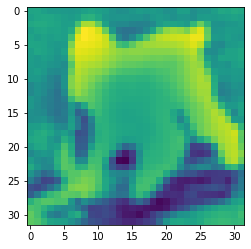

In [98]:
plt.imshow(seghead(seg_base[0])[0,:,:,0])

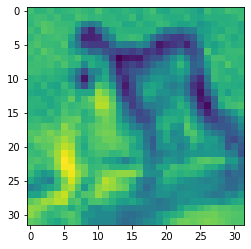

In [99]:
plt.imshow(conv[0,:,:,0])